# CS4248 Project - Labelled Unreliable News (LUN)

## Imports

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import string
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
!pip install sumy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'll": "i will",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "must've": "must have",
    "mustn't": "must not",
    "needn't": "need not",
    "oughtn't": "ought not",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "that'd": "that would",
    "that's": "that is",
    "there'd": "there had",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "where'd": "where did",
    "where's": "where is",
    "who'll": "who will",
    "who's": "who is",
    "won't": "will not",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are"
}

stop_words = set(stopwords.words('english'))
# stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stemmer = None
# lemmatizer = None

TEST_SIZE = 0.1

## Helper Functions

In [ ]:
def preprocess(sentence, lower_case=True, remove_punctuation=True, replace_contractions=True):
    if lower_case:
        sentence = sentence.lower()
    if remove_punctuation:
        sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    if replace_contractions:
        news = sentence.split()
        new_news = []
        for word in news:
            if word in contractions:
                new_news.append(contractions[word])
            else:
                new_news.append(word)
        sentence = " ".join(new_news)
    return sentence

In [ ]:
def tokenize(sentence, stemmer=stemmer, lemmatizer=lemmatizer, remove_stop_words=True):
    tokens = word_tokenize(sentence)
    
    if remove_stop_words:
        tokens = [token for token in tokens if token not in stop_words]
    if stemmer:
        tokens = [stemmer.stem(token) for token in tokens]
    if lemmatizer:
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        
    return tokens

## Load Data

In [ ]:
full_train_df = pd.read_csv('raw_data/fulltrain.csv', header=None)
full_train_df.columns = ['label', 'text']
full_train_df.head()

,label,text
0,1,"A little less than a decade ago, hockey fans w..."
1,1,The writers of the HBO series The Sopranos too...
2,1,Despite claims from the TV news outlet to offe...
3,1,After receiving 'subpar' service and experienc...
4,1,After watching his beloved Seattle Mariners pr...


In [ ]:
train_df = full_train_df.drop_duplicates(subset=['text'])
print(f"No. training samples (all classes): {len(train_df)}")

sample_df = train_df.groupby('label').apply(lambda x: x.sample(frac=0.25))
print(f"No. training samples (sampled classes): {len(sample_df)}")


No. training samples (all classes): 48652
No. training samples (sampled classes): 12164


## Preprocessing

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer

encoder = OneHotEncoder(sparse=False)

X = sample_df['text'].values
y = encoder.fit_transform(sample_df[['label']])
print("Before:", X[0])

Before: Claiming that the third-grader refuses to acknowledge anyone elses involvement in the situation, sources confirmed Monday that egocentric 8-year-old Dylan Fielder blames the divorce of his parents entirely on himself. Dylan is preoccupied with the extremely selfish notion that hes the sole influence on his parents marital problems, insisting that he could have acted better or done more to make them get along, as if hes the only thing that matters in this situation, said Fielders school guidance counselor, Sharon Thomas, adding that the boy is so narcissistic that he quickly dismissed the idea that financial and psychological factors played a role in his parents recent divorce and failed to even consider that the couples deep-seated communication issues could possibly be more important than he is. Ive tried to make it evident to Dylan that theres more to his parents fighting and separation than just him, but frankly, hes too self-absorbed to see anything else. Thomas told report

In [ ]:
# Check labels assigned to categories
display(sample_df.head())
print(y[0], y[-1])
encoder.categories_

label                                               text
label                                                                
1     11422      1  Claiming that the third-grader refuses to ackn...
      1950       1  Steadfastly staring at his iPhone screen as th...
      3505       1  This week the <a href='http://www.theonion.com...
      12362      1  In a historic United Nations summit Tuesday, t...
      3116       1  A 24-minute, 10-store dadhunt came to an end M...

[1. 0. 0. 0.] [0. 0. 0. 1.]


[array([1, 2, 3, 4])]

In [ ]:
from sumy.summarizers.lsa import LsaSummarizer as Summarizer
from sumy.nlp.tokenizers import Tokenizer
from sumy.parsers.plaintext import PlaintextParser


def summarize_text(text, num_sentences):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = Summarizer()
    summary = summarizer(parser.document, num_sentences)
    return " ".join([str(sentence) for sentence in summary])
    
# parser = PlaintextParser.from_string(X[0], Tokenizer("english"))
# summarizer = Summarizer()
# num_sentences = 3
# summary = summarizer(parser.document, num_sentences)

# for sentence in summary:
#     print(sentence)

num_sentences = 10
X = [summarize_text(text, num_sentences) for text in X]

In [ ]:
X = [preprocess(sentence) for sentence in X]
X = [tokenize(sentence) for sentence in X]
print("After:", X[0])

After: ['claiming', 'thirdgrader', 'refuse', 'acknowledge', 'anyone', 'el', 'involvement', 'situation', 'source', 'confirmed', 'monday', 'egocentric', '8yearold', 'dylan', 'fielder', 'blame', 'divorce', 'parent', 'entirely', 'dylan', 'preoccupied', 'extremely', 'selfish', 'notion', 'he', 'sole', 'influence', 'parent', 'marital', 'problem', 'insisting', 'could', 'acted', 'better', 'done', 'make', 'get', 'along', 'he', 'thing', 'matter', 'situation', 'said', 'fielder', 'school', 'guidance', 'counselor', 'sharon', 'thomas', 'adding', 'boy', 'narcissistic', 'quickly', 'dismissed', 'idea', 'financial', 'psychological', 'factor', 'played', 'role', 'parent', 'recent', 'divorce', 'failed', 'even', 'consider', 'couple', 'deepseated', 'communication', 'issue', 'could', 'possibly', 'important', 'ive', 'tried', 'make', 'evident', 'dylan', 'there', 'parent', 'fighting', 'separation', 'frankly', 'he', 'selfabsorbed', 'see', 'anything', 'else', 'thomas', 'told', 'reporter', 'would', 'surprised', 'dyl

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=42)
len(X_train), len(X_test)

(10947, 1217)

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=None, oov_token="<OOV>")    # num_words: the maximum number of words to keep, based on word frequency. 
                                                            # Only the most common num_words-1 words will be kept. If none, no limit is set.

tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)    # Transforms each text in texts to a sequence of integers.
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
from tensorflow.keras.utils import pad_sequences

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
print("Vocab size:", vocab_size, '\n')            # To be used in Embedding layer

def calculate_max_sentence_length(sentences):
    word_count = lambda sentence: len(sentence)
    longest_sentence = max(X_train, key=word_count)
    maxlen = len(longest_sentence) + 10
    print(longest_sentence, '\n')
    print(maxlen)
    return maxlen

# maxlen = 256
maxlen = calculate_max_sentence_length(X_train) + 16
print(f'Max sentence length: {maxlen}')

X_train = pad_sequences(X_train, padding='post', truncating='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', truncating='post', maxlen=maxlen)
len(X_train), len(X_train[0])

Vocab size: 75282 

[721, 1484, 76, 711, 57, 62810, 230, 727, 3225, 28163, 520, 23876, 4302, 2480, 14283, 19385, 366, 24, 764, 8, 4771, 33, 158, 802, 116, 143, 310, 5259, 8612, 34, 115, 86, 10, 6, 275, 9548, 10, 655, 1462, 6326, 1604, 189, 1381, 4950, 870, 2716, 486, 255, 724, 47, 516, 14654, 655, 235, 64, 354, 2111, 3582, 11056, 4471, 3514, 8108, 15, 4762, 1680, 2284, 9, 296, 127, 5499, 7126, 869, 6260, 358, 442, 392, 3772, 450, 512, 1048, 88, 750, 2501, 2319, 57, 1093, 443, 6, 2037, 2995, 5437, 9, 2908, 283, 9388, 931, 2452, 1970, 1227, 5570, 382, 34, 8, 4635, 18724, 47, 516, 166, 257, 23, 62, 80, 3057, 1638, 24579, 113, 516, 152, 297, 3189, 417, 8982, 421, 504, 62811, 36, 158, 1964, 2926, 58, 40, 1276, 29, 711, 2343, 491, 536, 2262, 4696, 684, 509, 3638, 684, 13440, 684, 13891, 684, 1108, 1206, 684, 62812, 26881, 13549, 7349, 62813, 657, 23481, 1752, 62814, 184, 684, 33517, 684, 24305, 684, 26882, 7856, 684, 9211, 684, 7889, 684, 62815, 684, 896, 4857, 684, 896, 3692, 684, 26883, 16

(10947, 549)

In [ ]:
glove_dir = '/content/drive/MyDrive/NUS/Y3S2/CS4248/glove.840B.300d.txt'
embeddings_index = {}

with open(glove_dir, encoding='utf-8') as f:
    for line in f:
        # values = line.split()
        values = line.strip().split(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
        
print(f'Found {len(embeddings_index)} word vectors.')

Found 2196007 word vectors.


In [ ]:
# Number of dimensions is 300 in glove.840B.300d.txt
print(len(embeddings_index['the']))
print(len(embeddings_index['happy']))

300
300


In [ ]:
embedding_dim = 300

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [ ]:
print(y_test.shape)
print(X_test.shape)
print(y_train.shape)
print(X_train.shape)

(1217, 4)
(1217, 549)
(10947, 4)
(10947, 549)


## Training

In [ ]:
from keras.models import Sequential
from keras import layers 

model = Sequential()
input_dim = X_train.shape[1]
num_cats = 4

def build_embconvmax_model():
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(128, 4, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(num_cats, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.summary()

def build_embpre_model():
    model.add(layers.Embedding(vocab_size, embedding_dim, 
                               weights=[embedding_matrix], 
                               input_length=maxlen, 
                               trainable=True))
    model.add(layers.Conv1D(128, 3, activation='relu'))
    model.add(layers.Dropout(0.5))    
    model.add(layers.GlobalMaxPool1D())
    model.add(layers.Dropout(0.5))    
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(num_cats, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.summary()

In [ ]:
# Define Callbacks
import tensorflow as tf
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

monitor = EarlyStopping(monitor='val_loss', 
                        min_delta=1e-3, 
                        patience=5, 
                        verbose=1, 
                        mode='auto',
                        restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

In [ ]:
def train_model(X_train, Y_train, X_test, Y_test):
    return model.fit(
        X_train,
        Y_train,
        epochs=256,
        validation_data=(X_test, Y_test),
        batch_size=16,
        callbacks=[monitor, reduce_lr],
    )

In [ ]:
def evaluate_model(X_train, Y_train, X_test, Y_test):
    loss, accuracy = model.evaluate(X_train, Y_train, verbose=False)
    print("Training Loss: {:.4f}".format(loss))
    print("Training Accuracy: {:.4f}".format(accuracy))
    loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
    print("Testing Loss:  {:.4f}".format(loss))
    print("Testing Accuracy:  {:.4f}".format(accuracy))

In [ ]:
# Helper function to visualize the loss and accuracy for the training and testing data based on the History callback. 
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

### Model 1: Embeddings + Convolution Layer + MaxPooling Layer

In [ ]:
build_embconvmax_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 549, 300)          22584600  
                                                                 
 conv1d (Conv1D)             (None, 546, 128)          153728    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dense_1 (Dense)             (None, 4)                 44        
                                                                 
Total params: 22,739,662
Trainable params: 22,739,662
Non-trainable params: 0
____________________________________________

In [ ]:
history = train_model(X_train, y_train, X_test, y_test)


Epoch 1/256
685/685 [==============================] - 106s 136ms/step - loss: 0.5684 - accuracy: 0.7802 - val_loss: 0.2999 - val_accuracy: 0.8891 - lr: 0.0010
Epoch 2/256
685/685 [==============================] - 36s 52ms/step - loss: 0.0745 - accuracy: 0.9774 - val_loss: 0.2283 - val_accuracy: 0.9145 - lr: 0.0010
Epoch 3/256
685/685 [==============================] - 19s 28ms/step - loss: 0.0045 - accuracy: 0.9995 - val_loss: 0.2371 - val_accuracy: 0.9113 - lr: 0.0010
Epoch 4/256
685/685 [==============================] - 17s 25ms/step - loss: 9.7881e-04 - accuracy: 0.9999 - val_loss: 0.2381 - val_accuracy: 0.9178 - lr: 0.0010
Epoch 5/256
685/685 [==============================] - 14s 21ms/step - loss: 3.3257e-04 - accuracy: 1.0000 - val_loss: 0.2439 - val_accuracy: 0.9178 - lr: 0.0010
Epoch 6/256
685/685 [==============================] - 13s 19ms/step - loss: 1.9251e-04 - accuracy: 1.0000 - val_loss: 0.2489 - val_accuracy: 0.9178 - lr: 0.0010
Epoch 7/256
685/685 [=================

Training Loss: 0.0061
Training Accuracy: 0.9996
Testing Loss:  0.2283
Testing Accuracy:  0.9145


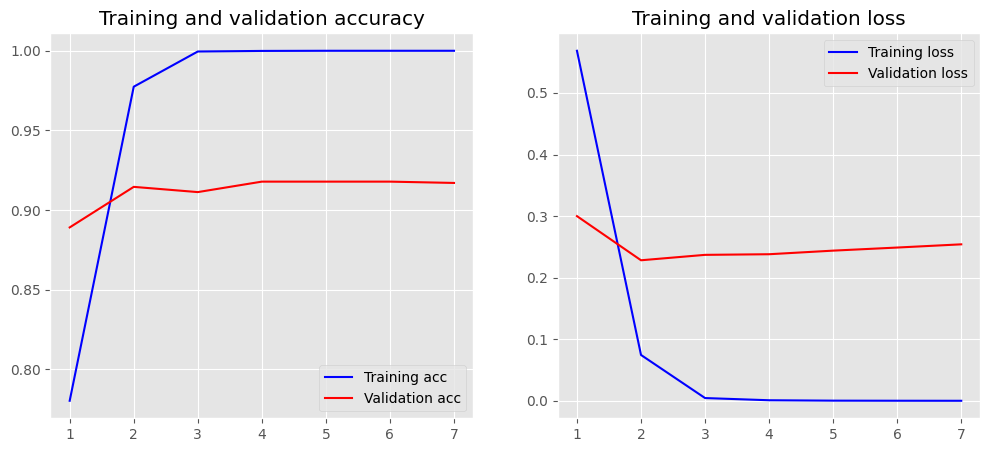

In [ ]:
evaluate_model(X_train, y_train, X_test, y_test)
plot_history(history)

## Validation - Model 1

In [ ]:
test_df = pd.read_csv('raw_data/balancedtest.csv', header=None, names=['label', 'text'])
print(f"No. test samples (all classes): {len(test_df)}")
test_df.sample(5)

No. test samples (all classes): 3000


,label,text
1762,3,Xanthan gum was discovered in the 1960s and w...
1455,2,WATCH: White Man Jailed for a Traffic Ticket D...
81,1,"Late in the afternoon on Tuesday, Fox News Cha..."
2204,3,Of all the times Republicans have made fun of...
632,1,Fox News announced on Wednesday that it is ter...


In [ ]:
X_val = test_df['text'].values
y_val = test_df['label'].values

# Do the same preprocessing steps as training data: preprocess, tokenize, pad sequences
X_val = [preprocess(sentence) for sentence in X_val]
X_val = [tokenize(sentence) for sentence in X_val]
print("After:", X_val[0])


After: ['many', 'actor', 'seem', 'content', 'churn', 'performance', 'quick', 'paycheck', 'performer', 'adheres', 'principle', 'really', 'stand', 'thats', 'jeff', 'bridge', 'made', 'wave', 'week', 'announced', 'perform', 'nude', 'scene', 'interview', 'month', 'gq', 'big', 'lebowski', 'star', 'made', 'clear', 'ready', 'move', 'new', 'phase', 'career', 'leaving', 'clothed', 'role', 'past', 'ive', 'ive', 'done', 'said', 'bridge', 'rattling', 'laundry', 'list', 'film', 'he', 'appeared', 'covered', 'finally', 'afford', 'take', 'role', 'excite', 'right', 'role', 'nude', 'scene', 'waste', 'time', 'anything', 'else', 'powerful', 'though', 'made', 'clear', 'doesnt', 'regret', 'previous', 'nonnude', 'role', 'jeff', 'admitted', 'hed', 'always', 'struggled', 'pressure', 'director', 'studio', 'stay', 'clothed', 'camera', 'towel', 'bathrobe', 'carefully', 'placed', 'plant', 'added', 'even', 'character', 'isnt', 'written', 'nude', 'director', 'work', 'figure', 'make', 'way', 'itll', 'challenge', 'u', 

In [ ]:
X_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)
len(X_val[0])

549

In [ ]:
y_pred = model.predict(X_val)
predicted_indexes = np.argmax(y_pred, axis=1)
y_pred_val = [pred_class + 1 for pred_class in predicted_indexes]
y_pred_val[:5]

94/94 [==============================] - 1s 4ms/step


[1, 1, 1, 4, 4]

In [ ]:
# y_pred_val = model.predict(X_val)
print(f"Accuracy: {accuracy_score(y_val, y_pred_val)}")
print(f"F1 score: {f1_score(y_val, y_pred_val, average='macro')}")

Accuracy: 0.639
F1 score: 0.6251024786192263


In [ ]:
print(classification_report(y_val, y_pred_val, target_names=['satire', 'hoax', 'propaganda', 'reliable']))

              precision    recall  f1-score   support

      satire       0.80      0.58      0.67       750
        hoax       0.70      0.32      0.44       750
  propaganda       0.51      0.86      0.64       750
    reliable       0.70      0.79      0.75       750

    accuracy                           0.64      3000
   macro avg       0.68      0.64      0.63      3000
weighted avg       0.68      0.64      0.63      3000



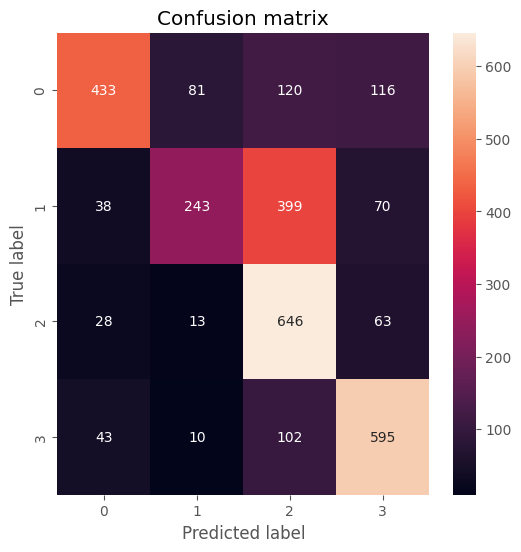

In [ ]:
cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()	

### Model 2. Embeddings

In [ ]:
build_embpre_model()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 549, 300)          22584600  
                                                                 
 conv1d (Conv1D)             (None, 546, 128)          153728    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dense_1 (Dense)             (None, 4)                 44        
                                                                 
 embedding_1 (Embedding)     (None, 4, 300)            22584600  
                                                        

In [ ]:
history = train_model(X_train, y_train, X_test, y_test)


Epoch 1/256


685/685 [==============================] - 11s 13ms/step - loss: 1.3501 - accuracy: 0.3655 - val_loss: 1.3328 - val_accuracy: 0.3673 - lr: 0.0010
Epoch 2/256
685/685 [==============================] - 7s 10ms/step - loss: 1.3300 - accuracy: 0.3673 - val_loss: 1.3286 - val_accuracy: 0.3673 - lr: 0.0010
Epoch 3/256
685/685 [==============================] - 7s 11ms/step - loss: 1.3283 - accuracy: 0.3673 - val_loss: 1.3282 - val_accuracy: 0.3673 - lr: 0.0010
Epoch 4/256
685/685 [==============================] - 7s 10ms/step - loss: 1.3282 - accuracy: 0.3673 - val_loss: 1.3282 - val_accuracy: 0.3673 - lr: 0.0010
Epoch 5/256
685/685 [==============================] - 8s 11ms/step - loss: 1.3282 - accuracy: 0.3673 - val_loss: 1.3281 - val_accuracy: 0.3673 - lr: 0.0010
Epoch 6/256
685/685 [==============================] - 7s 10ms/step - loss: 1.3281 - accuracy: 0.3673 - val_loss: 1.3281 - val_accuracy: 0.3673 - lr: 0.0010
Epoch 7/256
685/685 [==============================] - 8s 11ms/step -

Training Loss: 1.3285
Training Accuracy: 0.3673
Testing Loss:  1.3286
Testing Accuracy:  0.3673


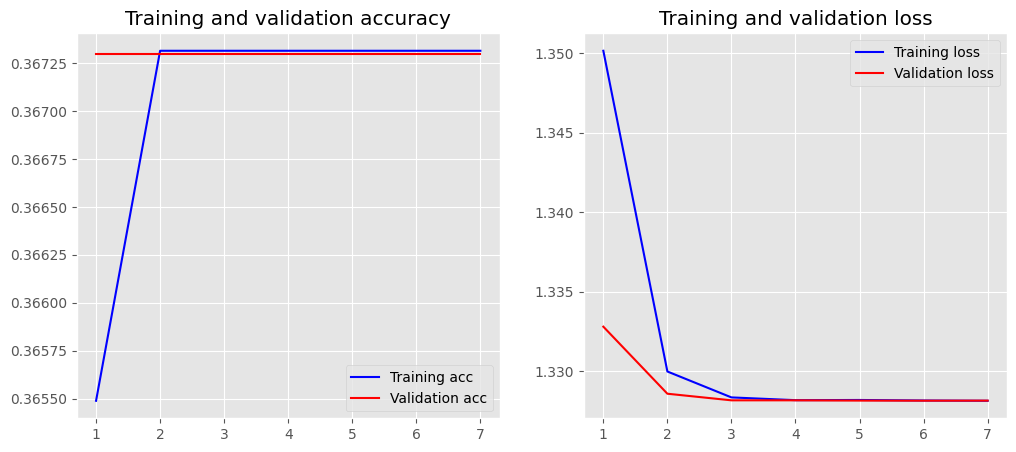

In [ ]:
evaluate_model(X_train, y_train, X_test, y_test)
plot_history(history)

## Validation - Model 2

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/NUS/Y3S2/CS4248/balancedtest.csv', header=None, names=['label', 'text'])
print(f"No. test samples (all classes): {len(test_df)}")
test_df.sample(5)

No. test samples (all classes): 3000


,label,text
645,1,President Obama used his weekly radio address ...
2486,4,The Obama administration indicated to reporter...
794,2,THIS is what REAL racism looks like: Group of ...
1059,2,McCarthy Says Shes Killing US Economy - To Sho...
1477,2,Soros To Hillary: Clean Up On Aisle 9 - ONE OR...


In [ ]:
X_val = test_df['text'].values
y_val = test_df['label'].values

# Do the same preprocessing steps as training data: preprocess, tokenize, pad sequences
X_val = [preprocess(sentence) for sentence in X_val]
X_val = [tokenize(sentence) for sentence in X_val]
print("After:", X_val[0])


After: ['many', 'actor', 'seem', 'content', 'churn', 'performance', 'quick', 'paycheck', 'performer', 'adheres', 'principle', 'really', 'stand', 'thats', 'jeff', 'bridge', 'made', 'wave', 'week', 'announced', 'perform', 'nude', 'scene', 'interview', 'month', 'gq', 'big', 'lebowski', 'star', 'made', 'clear', 'ready', 'move', 'new', 'phase', 'career', 'leaving', 'clothed', 'role', 'past', 'ive', 'ive', 'done', 'said', 'bridge', 'rattling', 'laundry', 'list', 'film', 'he', 'appeared', 'covered', 'finally', 'afford', 'take', 'role', 'excite', 'right', 'role', 'nude', 'scene', 'waste', 'time', 'anything', 'else', 'powerful', 'though', 'made', 'clear', 'doesnt', 'regret', 'previous', 'nonnude', 'role', 'jeff', 'admitted', 'hed', 'always', 'struggled', 'pressure', 'director', 'studio', 'stay', 'clothed', 'camera', 'towel', 'bathrobe', 'carefully', 'placed', 'plant', 'added', 'even', 'character', 'isnt', 'written', 'nude', 'director', 'work', 'figure', 'make', 'way', 'itll', 'challenge', 'u', 

In [ ]:
X_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)
len(X_val[0])

549

In [ ]:
y_pred = model.predict(X_val)
predicted_indexes = np.argmax(y_pred, axis=1)
y_pred_val = [pred_class + 1 for pred_class in predicted_indexes]
y_pred_val[:5]

94/94 [==============================] - 1s 4ms/step


[3, 3, 3, 3, 3]

In [ ]:
# y_pred_val = model.predict(X_val)
print(f"Accuracy: {accuracy_score(y_val, y_pred_val)}")
print(f"F1 score: {f1_score(y_val, y_pred_val, average='macro')}")

Accuracy: 0.25
F1 score: 0.1


In [ ]:
print(classification_report(y_val, y_pred_val, target_names=['satire', 'hoax', 'propaganda', 'reliable']))

              precision    recall  f1-score   support

      satire       0.00      0.00      0.00       750
        hoax       0.00      0.00      0.00       750
  propaganda       0.25      1.00      0.40       750
    reliable       0.00      0.00      0.00       750

    accuracy                           0.25      3000
   macro avg       0.06      0.25      0.10      3000
weighted avg       0.06      0.25      0.10      3000



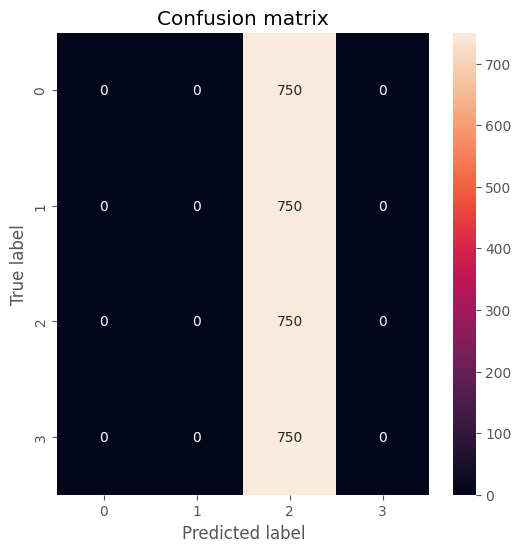

In [ ]:
cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()	